In [11]:
#Original code by Dr. Liu and Dr. Liu

In [1]:
import os
import glob
import numpy as np
import time

In [2]:
#from skimage.io import imread, imsave
from cv2 import imread, imwrite

In [3]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.python.keras.layers import LeakyReLU, Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.utils import multi_gpu_model

In [4]:
import matplotlib.pyplot as plt

In [5]:
def cleanup():
    print('cleaning previous image outputs.')
    fileList = glob.glob('mnist_256*.png')
    for file in fileList:
        os.remove(file)
    print('done')

In [6]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [11]:
def load_data(directory_path):
    train_data = []
    for file_ in sorted(os.listdir(directory_path)):
        if file_.endswith('.png'):
            if directory_path.endswith('/'):
                 image_path = directory_path + file_
            else: image_path = directory_path + '/' + file_

            #image = imread(image_path)/255.0 # Normalize values
            print('normalizing image:',image_path)
            image = imread(image_path, 0) # load as grayscale
            if np.max(image) > 1.:
                image = image / 255.0 #normalize values
            #print(image.shape)
            image = np.expand_dims(image, axis=-1) # Add channel dim
            train_data.append(image)
            print('done')
    
    train_data = np.array(train_data)
    return train_data

In [12]:
class DCGAN(object):
    def __init__(self, img_rows=256, img_cols=256, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W-F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.2
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*2, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.2
        depth = 64+64+64+64
        dim = 8
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        # Out: 256 x 256 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=2e-4, decay=0.001)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        
        #multi_gpu
        #with tf.device('/cpu:0'):
         #   self.DM = multi_gpu_model(self.DM, gpus=4)
            
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=1e-4, decay=0.001)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        
        #multi_gpu
        #with tf.device('/cpu:0'):
         #   self.AM = multi_gpu_model(self.AM, gpus=4)
            
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [41]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 256
        self.img_cols = 256
        self.channel = 1

        print('loading data')
        self.x_train = load_data('img/sample/') # Change to Path to Image directory
        print('done')

        print('creating DCGAN object')
        self.DCGAN = DCGAN()
        print('done')
        
        print('creating discriminator object')
        self.discriminator =  self.DCGAN.discriminator_model()
        print('done')
        
        print('creating adversarial object')
        self.adversarial = self.DCGAN.adversarial_model()
        print('done')
        
        print('creating generator')
        self.generator = self.DCGAN.generator()
        print('done')
        
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        print(self.x_train.shape[0])
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            #print(len(images_fake[0]))
            imgplot = plt.imshow(images_train[0][0])
            plt.show()
            #print(len(images_train[0]))
            #print(len(images_fake[0]))
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'chestxray_256.png'
        if fake:
            filename = 'chestxray_fake_256.png'
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_256_%04d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
    
    def gen_images(self):
        noise = np.random.uniform(-1.0, 1.0, size=[5000, 100])
        images = self.generator.predict(noise)
        
        path = 'fake_256_noFinding'
        for i in range(len(images)):
            img = np.reshape(images[i], [256, 256])*255
            imsave(os.path.join(path, str(i).zfill(4) + '.png'), img.astype(np.uint8))

cleaning previous image outputs.
done
creating MNIST_DCGAN
loading data
normalizing image: img/sample/00020424_004.png
done
done
creating DCGAN object
done
creating discriminator object
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 128, 128, 64)      1664      
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 64, 64, 128)       204928    
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________

TypeError: Invalid dimensions for image data

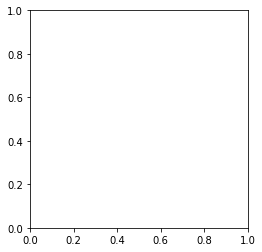

In [42]:
if __name__ == '__main__':
    #remove old output images
    cleanup()
    
    print('creating MNIST_DCGAN')
    mnist_dcgan = MNIST_DCGAN()
    print('done')

    timer = ElapsedTimer()
#    mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
    #mnist_dcgan.train(train_steps=4000, batch_size=64, save_interval=10)
    mnist_dcgan.train(train_steps=1, batch_size=1, save_interval=10)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True, save2file=True)
#    mnist_dcgan.plot_images(fake=False, save2file=True)